In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
sns.set()

### Load Dataset

In [2]:
raw_df = pd.read_csv('loan_data_2007_2014.csv',index_col=0)
raw_df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
raw_df.shape

(466285, 74)

In [4]:
raw_df['loan_status'].value_counts(normalize=True) * 100

Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: loan_status, dtype: float64

#### The goal of this PD model is assess default probability of new applicant hence selecting only loan status with Current, fully paid and Charged off

In [5]:
sub_df = raw_df[raw_df['loan_status'].isin(['Current','Fully Paid','Charged Off'])].copy()
sub_df.shape

(451440, 74)

In [6]:
sub_df['loan_status'].value_counts(normalize=True)*100

Current        49.669059
Fully Paid     40.922160
Charged Off     9.408781
Name: loan_status, dtype: float64

#### Splitting the dataset into Train, Test and eval 

In [7]:
raw_test = sub_df[sub_df['loan_status']=='Current'].copy()
raw_test.shape

(224226, 74)

In [8]:
train_eval = sub_df[sub_df['loan_status']!='Current']
raw_train, raw_eval = train_test_split(train_eval, test_size=0.20, random_state=42,stratify=train_eval['loan_status'])
raw_train.shape, raw_eval.shape

((181771, 74), (45443, 74))

In [9]:
raw_train['loan_status'].value_counts(normalize=True)

Fully Paid     0.813061
Charged Off    0.186939
Name: loan_status, dtype: float64

In [10]:
raw_eval['loan_status'].value_counts(normalize=True)

Fully Paid     0.813063
Charged Off    0.186937
Name: loan_status, dtype: float64

### Train Preprocessing

In [11]:
raw_train.isna().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       10133
emp_length                       6938
home_ownership                      0
annual_inc                          0
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           111268
purpose                             0
title                               7
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                         0
earliest_cr_

### Slecting variable available at the time of new loan application

In [12]:
applicant_features = ['id','member_id','loan_amnt','term','grade','emp_length','home_ownership',
                     'annual_inc','verification_status','purpose','addr_state','dti','delinq_2yrs',
                      'earliest_cr_line','total_acc','loan_status',]

In [13]:
train_df = raw_train[applicant_features].copy()
train_df.sample(3)

,id,member_id,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,total_acc,loan_status
37039,386587,418979,10000,36 months,C,1 year,OTHER,37800.0,Verified,car,NJ,10.38,0.0,Apr-00,24.0,Charged Off
117707,6175817,7667962,21000,36 months,C,10+ years,OWN,56000.0,Verified,debt_consolidation,IL,10.99,0.0,Jan-91,19.0,Fully Paid
213345,1336847,1581800,20000,60 months,C,1 year,RENT,60000.0,Verified,debt_consolidation,IL,20.70,0.0,May-82,27.0,Fully Paid


In [14]:
train_df.isna().sum()

id                        0
member_id                 0
loan_amnt                 0
term                      0
grade                     0
emp_length             6938
home_ownership            0
annual_inc                0
verification_status       0
purpose                   0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
total_acc                 0
loan_status               0
dtype: int64

In [15]:
# converting term from str to int
train_df['term'] = train_df['term'].apply(lambda x : x.split()[0])
train_df['term'] = train_df['term'].astype(int)
train_df['term'].sample(3)

347274    36
429884    60
211226    36
Name: term, dtype: int32

In [16]:
train_df['emp_length'].unique()

array(['10+ years', '5 years', '4 years', '9 years', '8 years', nan,
       '2 years', '3 years', '< 1 year', '6 years', '7 years', '1 year'],
      dtype=object)

In [17]:
# filling nan and < 1 year to 0 years in employment length
train_df['emp_length'].replace({np.nan :'0 year','< 1 year':'0 year'},inplace=True)

# extracting employment years from str using regex
train_df['emp_length'] = train_df['emp_length'].apply(lambda x : re.findall(r'\d+', x)[0])

# converting emp_length from str to int
train_df['emp_length'] = train_df['emp_length'].astype(int)

train_df['emp_length'].sample(3)

99165      6
44627     10
337057     6
Name: emp_length, dtype: int32

In [18]:
train_df['emp_length'].value_counts()

10    54391
0     21973
2     17051
3     14744
5     13311
1     12079
4     11787
6     10830
7     10312
8      8432
9      6861
Name: emp_length, dtype: int64

In [19]:
train_df['earliest_cr_line'].sample(3)

374431    Sep-07
412296    Feb-07
104556    Mar-06
Name: earliest_cr_line, dtype: object

In [20]:
# converting earliest_cr_line to pandas datetime format
train_df['earliest_cr_line'] = pd.to_datetime(train_df['earliest_cr_line'],format='%b-%y')
train_df['earliest_cr_line'].sample(3,random_state=23)

313393   1992-07-01
203924   1998-11-01
158649   2001-12-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [21]:
train_df['earliest_cr_line'].describe()

count                  181771
unique                    627
top       2000-10-01 00:00:00
freq                     1545
first     1969-01-01 00:00:00
last      2068-12-01 00:00:00
Name: earliest_cr_line, dtype: object

In [22]:
# we see that last year is 2068 which is impossible as current dataset is dated 2014.
# subtracting 100 from the year where year value is greater than 2015
train_df['earliest_cr_line'] = train_df['earliest_cr_line'].apply(lambda x: x - pd.DateOffset(years=100) if x.year > 2014 else x)
train_df['earliest_cr_line'].describe()

count                  181771
unique                    627
top       2000-10-01 00:00:00
freq                     1545
first     1946-01-01 00:00:00
last      2011-11-01 00:00:00
Name: earliest_cr_line, dtype: object

In [23]:
# convert earlierst cr line to months by subtracting it from reference date.
ref_date = '2020-01-01'
train_df['credit_hist'] = pd.to_datetime(ref_date) - train_df['earliest_cr_line']

# converting credit hist to months
train_df['credit_hist'] = train_df['credit_hist'].dt.days//30
train_df['credit_hist'] = train_df['credit_hist'].astype(int)
train_df['credit_hist'].describe()

count    181771.000000
mean        267.777940
std          84.563009
min          99.000000
25%         211.000000
50%         251.000000
75%         309.000000
max         900.000000
Name: credit_hist, dtype: float64

In [24]:
# removing earliest cr line columns
train_df.drop('earliest_cr_line',axis='columns',inplace=True)

In [25]:
train_df.describe()

,id,member_id,loan_amnt,term,emp_length,annual_inc,dti,delinq_2yrs,total_acc,credit_hist
count,1.817710e+05,1.817710e+05,181771.000000,181771.000000,181771.000000,1.817710e+05,181771.000000,181771.000000,181771.000000,181771.000000
mean,8.344747e+06,9.448405e+06,13468.359502,41.138245,5.580621,7.211010e+04,16.368239,0.242756,24.813722,267.777940
std,9.086591e+06,9.867976e+06,8047.959417,9.844636,3.710852,5.483136e+04,7.675093,0.726203,11.611672,84.563009
min,5.473400e+04,7.069900e+04,500.000000,36.000000,0.000000,3.000000e+03,0.000000,0.000000,2.000000,99.000000
25%,1.385446e+06,1.619787e+06,7200.000000,36.000000,2.000000,4.500000e+04,10.660000,0.000000,16.000000,211.000000
50%,5.174718e+06,6.187092e+06,12000.000000,36.000000,5.000000,6.200000e+04,16.060000,0.000000,23.000000,251.000000
75%,1.225699e+07,1.394777e+07,18000.000000,36.000000,10.000000,8.611200e+04,21.790000,0.000000,32.000000,309.000000
max,3.785416e+07,4.061688e+07,35000.000000,60.000000,10.000000,6.100000e+06,39.990000,29.000000,118.000000,900.000000


In [26]:
train_df.describe(include=np.object)

,grade,home_ownership,verification_status,purpose,addr_state,loan_status
count,181771,181771,181771,181771,181771,181771
unique,7,6,3,14,50,2
top,B,MORTGAGE,Verified,debt_consolidation,CA,Fully Paid
freq,56203,89641,67929,105741,31064,147791


### Converting loan status to binary value


In [27]:
# creating target variable Good Loan which is set to 1 if loan is fully paid else it is 0
train_df['Good_loan'] = np.where(train_df['loan_status']=='Fully Paid',1,0)
train_df['Good_loan'].value_counts()

1    147791
0     33980
Name: Good_loan, dtype: int64

In [28]:
train_df.drop('loan_status',axis='columns',inplace=True)

### Function for calculating Weight of evidence and information value

WOE = ln(((Number of non-events in a group + 0.5) / Number of non-events)) / ((Number of events in a group + 0.5) / Number of events))

IV = ∑ (% of non-events - % of events) * WOE

In [29]:
def get_woe_iv(cat_column,df,target='Good_loan'):
    # compute good and bad count for each category
    woe_iv = df.groupby([cat_column,target]).size().unstack(fill_value=0)
    woe_iv.columns.name = ''
    
    # offsetting by 0.5 to for zero value
    woe_iv = woe_iv + 0.5 
    woe_iv.rename(columns={0:'Bad_loan',1:'Good_loan'},inplace=True)
    
    # computing weight of evidence
    woe_iv['Good_loan_prop'] = woe_iv['Good_loan']/woe_iv['Good_loan'].sum()
    woe_iv['Bad_loan_prop'] = woe_iv['Bad_loan']/woe_iv['Bad_loan'].sum()
    woe_iv['WOE'] = np.log(woe_iv['Good_loan_prop']/woe_iv['Bad_loan_prop'])
    
    # computing information value for each bin
    woe_iv['IV'] = (woe_iv['Good_loan_prop'] - woe_iv['Bad_loan_prop']) * woe_iv['WOE'] 
    
    # computing information value for category
    woe_iv['IV'] = woe_iv['IV'].sum()
    
    woe_iv.sort_values(by='WOE',inplace=True)
    
    return woe_iv

### Function for plotting WOE

In [30]:
def plot_by_woe(df, rotation_of_x_axis_labels = 0):
    x = df.index.astype(str).values
    y = df['WOE'].values
    plt.figure(figsize = (18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df.index.name)
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df.index.name))
    plt.xticks(rotation = rotation_of_x_axis_labels)

#### WOE & IV for Grade

In [31]:
grade_woe = get_woe_iv('grade',train_df)
grade_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
grade,,,,,,
G,572.5,727.5,0.004922,0.016846,-1.230346,0.38753
F,2150.5,3157.5,0.021364,0.063281,-1.085867,0.38753
E,4568.5,8451.5,0.057184,0.134433,-0.854789,0.38753
D,7809.5,20854.5,0.141105,0.229803,-0.487719,0.38753
C,9491.5,36521.5,0.247110,0.279297,-0.122443,0.38753
B,7368.5,48835.5,0.330428,0.216826,0.421296,0.38753
A,2022.5,29246.5,0.197886,0.059514,1.201478,0.38753


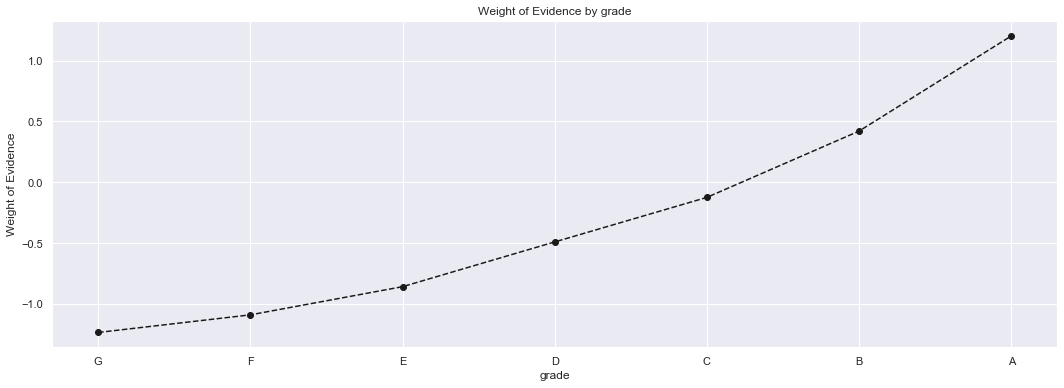

In [32]:
plot_by_woe(grade_woe)

IV value of 0.39 indicates that grade variable is an important predictior<br>
From Graph it is evident that there is no need for coarse classing grade variable

#### WOE & IV for home ownership

In [33]:
home_woe = get_woe_iv('home_ownership',train_df)
home_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
home_ownership,,,,,,
ANY,0.5,1.5,0.000010,0.000015,-0.371347,0.016244
RENT,15944.5,60809.5,0.411448,0.469190,-0.131327,0.016244
OWN,2985.5,12241.5,0.082828,0.087853,-0.058894,0.016244
OTHER,23.5,98.5,0.000666,0.000692,-0.036903,0.016244
MORTGAGE,15025.5,74616.5,0.504868,0.442148,0.132654,0.016244
NONE,3.5,26.5,0.000179,0.000103,0.554423,0.016244


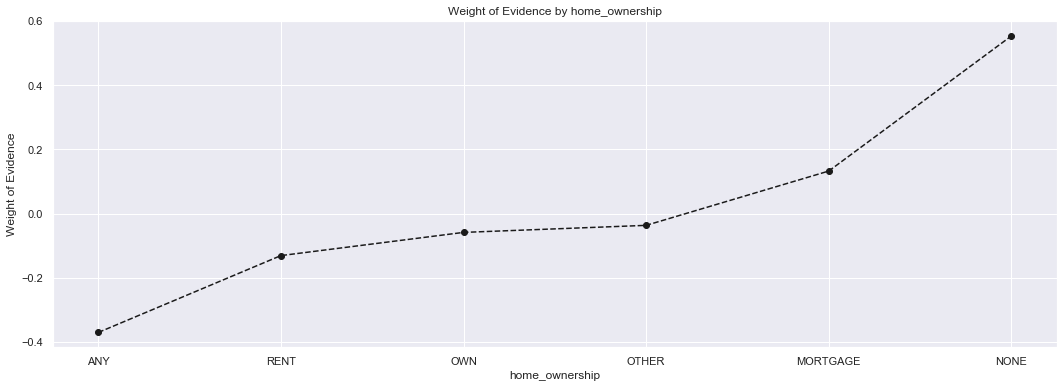

In [34]:
plot_by_woe(home_woe)

In [35]:
# coarse classing home ownership by combing categories with less obs/similary WOE values
# combining any and rent into any_rent
# combining own and other into own_other
# combining mortgage and none into mortgage_none
train_df['home_ownership'].replace({'ANY':'any_rent',
                                    'RENT':'any_rent',
                                    'OWN':'own_other',
                                    'OTHER':'own_other',
                                    'MORTGAGE':'mortgage_none',
                                    'NONE':'mortgage_none'}, inplace=True)

train_df['home_ownership'].value_counts()

mortgage_none    89670
any_rent         76754
own_other        15347
Name: home_ownership, dtype: int64

In [36]:
home_woe = get_woe_iv('home_ownership',train_df)
home_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
home_ownership,,,,,,
any_rent,15944.5,60810.5,0.411459,0.469211,-0.131344,0.016218
own_other,3008.5,12339.5,0.083492,0.088533,-0.058629,0.016218
mortgage_none,15028.5,74642.5,0.505049,0.442255,0.132769,0.016218


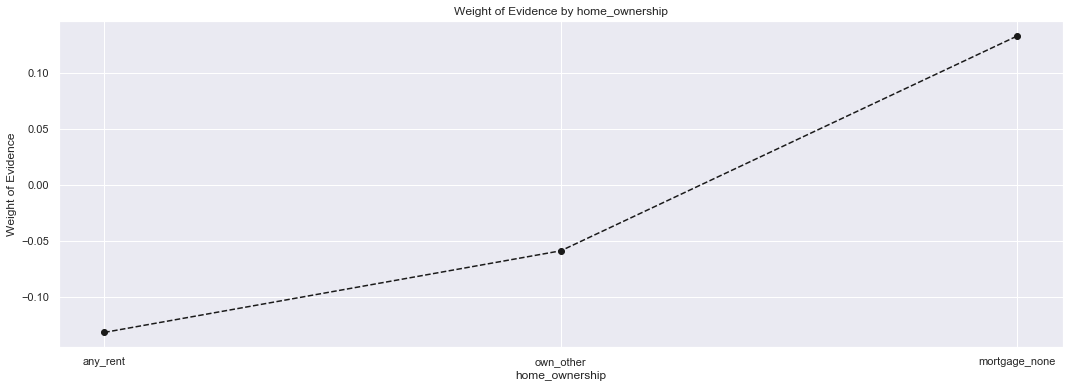

In [37]:
plot_by_woe(home_woe)

IV value of 0.01 < 0.02 indicates that home_ownership variable is not a usefult predictor

#### WOE & IV for Verification Status

In [38]:
verification_woe = get_woe_iv('verification_status',train_df)
verification_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
verification_status,,,,,,
Verified,14635.5,53294.5,0.360604,0.430690,-0.177610,0.042186
Source Verified,10111.5,40481.5,0.273908,0.297559,-0.082821,0.042186
Not Verified,9234.5,54016.5,0.365489,0.271751,0.296350,0.042186


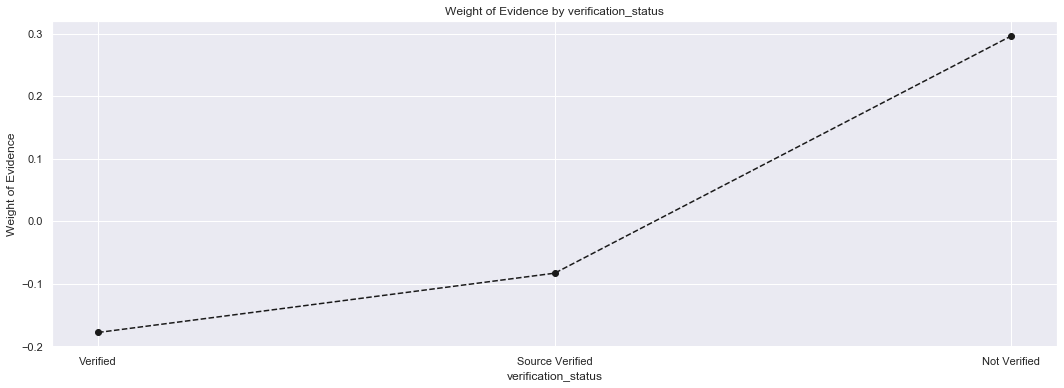

In [39]:
plot_by_woe(verification_woe)

IV value of 0.04 indicates that verification status variable is an weak predictior<br>
From Graph it is evident that there is no need for coarse classing grade variable

#### WOE & IV for addr state

In [40]:
addr_woe= get_woe_iv('addr_state',train_df)
addr_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
addr_state,,,,,,
NE,2.5,3.5,0.000024,0.000074,-1.132988,0.017547
IA,1.5,3.5,0.000024,0.000044,-0.622163,0.017547
TN,428.5,1217.5,0.008237,0.012601,-0.425197,0.017547
MS,58.5,176.5,0.001194,0.001720,-0.365167,0.017547
IN,444.5,1444.5,0.009772,0.013072,-0.290892,0.017547
NV,609.5,2112.5,0.014291,0.017924,-0.226472,0.017547
AL,507.5,1779.5,0.012039,0.014924,-0.214870,0.017547
ID,1.5,5.5,0.000037,0.000044,-0.170178,0.017547
NM,210.5,778.5,0.005267,0.006190,-0.161577,0.017547


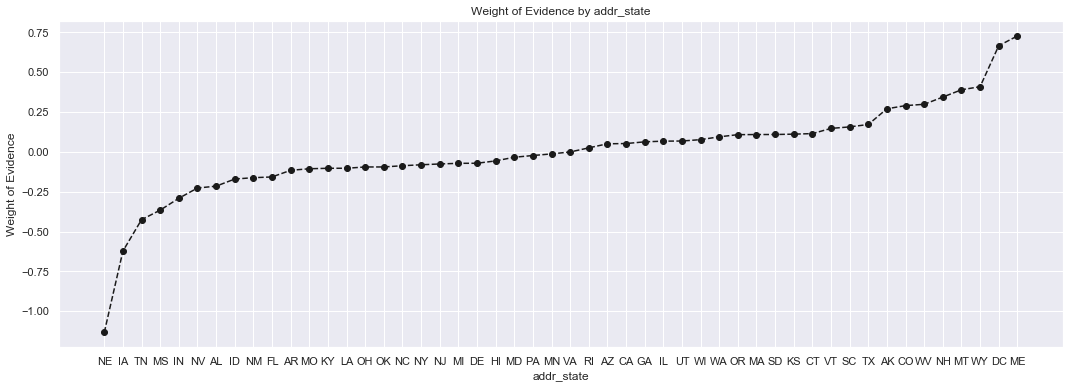

In [41]:
plot_by_woe(addr_woe)

IV value of 0.01 < 0.02 indicates that home_ownership variable is not a usefult predictor

#### WOE & IV for loan amount

(array([12869., 33075., 37987., 25556., 22749., 20739.,  8713.,  8721.,
         4426.,  6936.]),
 array([  500.,  3950.,  7400., 10850., 14300., 17750., 21200., 24650.,
        28100., 31550., 35000.]),
 <a list of 10 Patch objects>)

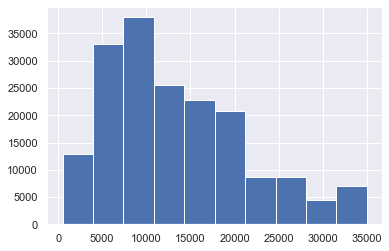

In [42]:
plt.hist(train_df['loan_amnt'])

In [43]:
train_df['loan_amnt_cat'],loan_amt_bin =  pd.cut(train_df['loan_amnt'],bins=5,retbins=True)
train_df['loan_amnt_cat'].sample(3)

268416    (21200.0, 28100.0]
149567    (28100.0, 35000.0]
570       (21200.0, 28100.0]
Name: loan_amnt_cat, dtype: category
Categories (5, interval[float64]): [(465.5, 7400.0] < (7400.0, 14300.0] < (14300.0, 21200.0] < (21200.0, 28100.0] < (28100.0, 35000.0]]

In [44]:
loan_amt_woe= get_woe_iv('loan_amnt_cat',train_df)
loan_amt_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
loan_amnt_cat,,,,,,
"(28100.0, 35000.0]",2763.5,8538.5,0.057773,0.081321,-0.341883,0.027981
"(21200.0, 28100.0]",3874.5,13454.5,0.091036,0.114015,-0.225073,0.027981
"(14300.0, 21200.0]",8893.5,34601.5,0.234121,0.261708,-0.111394,0.027981
"(7400.0, 14300.0]",11170.5,52450.5,0.354890,0.328713,0.076623,0.027981
"(465.5, 7400.0]",7280.5,38748.5,0.262180,0.214243,0.201922,0.027981


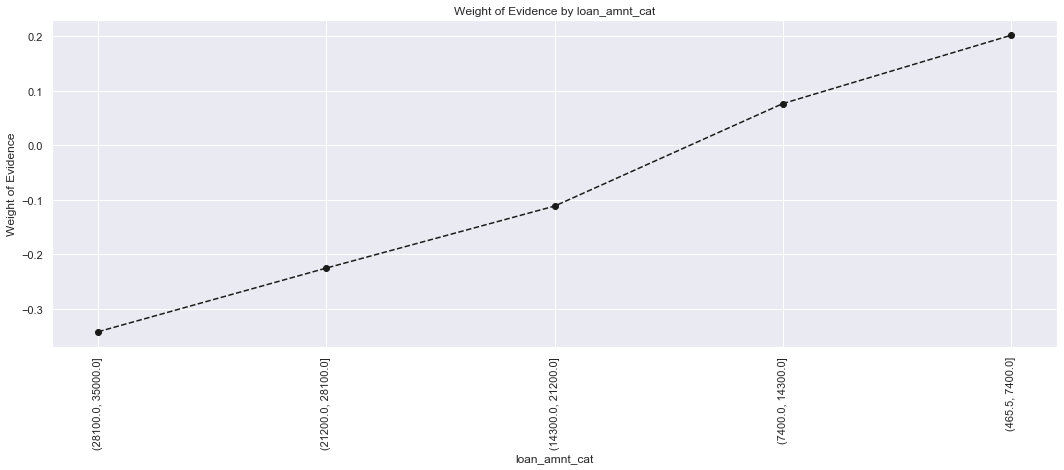

In [45]:
plot_by_woe(loan_amt_woe,90)

IV value of > 0.02 indicates that loan amount variable is an weak predictior<br>
From Graph it is evident that there is no need for coarse classing loam amount variable

#### WOE & IV for term

In [46]:
term_woe= get_woe_iv('term',train_df)
term_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
term,,,,,,
60,12052.5,26864.5,0.181772,0.354683,-0.668471,0.156635
36,21928.5,120927.5,0.818228,0.645317,0.237400,0.156635


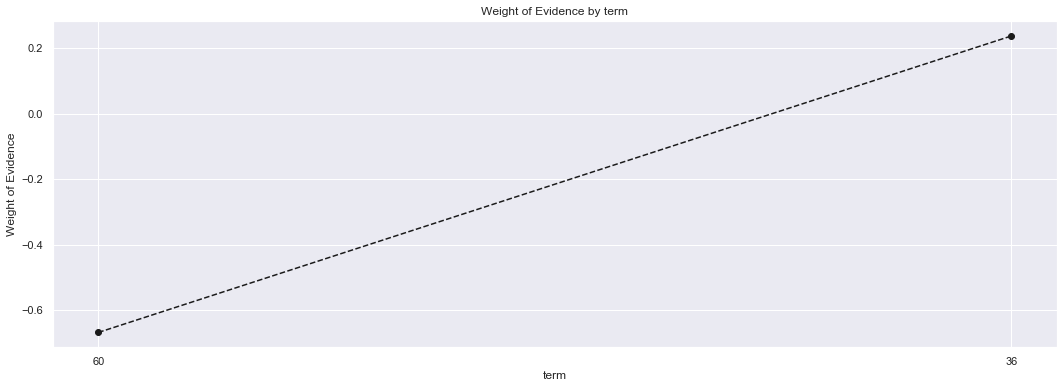

In [47]:
plot_by_woe(term_woe)

IV value of > 0.1 indicates that term variable is an medium predictior<br>
From Graph it is evident that there is no need for coarse classing term variable

#### WOE & IV for emp length

In [48]:
emp_len_woe= get_woe_iv('emp_length',train_df)
emp_len_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
emp_length,,,,,,
0,4693.5,17280.5,0.116921,0.138103,-0.166502,0.004916
9,1324.5,5537.5,0.037467,0.038973,-0.039394,0.004916
7,1989.5,8323.5,0.056317,0.058540,-0.038703,0.004916
8,1609.5,6823.5,0.046168,0.047358,-0.025453,0.004916
6,2051.5,8779.5,0.059403,0.060364,-0.016054,0.004916
5,2457.5,10854.5,0.073442,0.072310,0.015533,0.004916
3,2686.5,12058.5,0.081589,0.079048,0.031628,0.004916
1,2199.5,9880.5,0.066852,0.064719,0.032431,0.004916
10,9828.5,44563.5,0.301519,0.289197,0.041726,0.004916


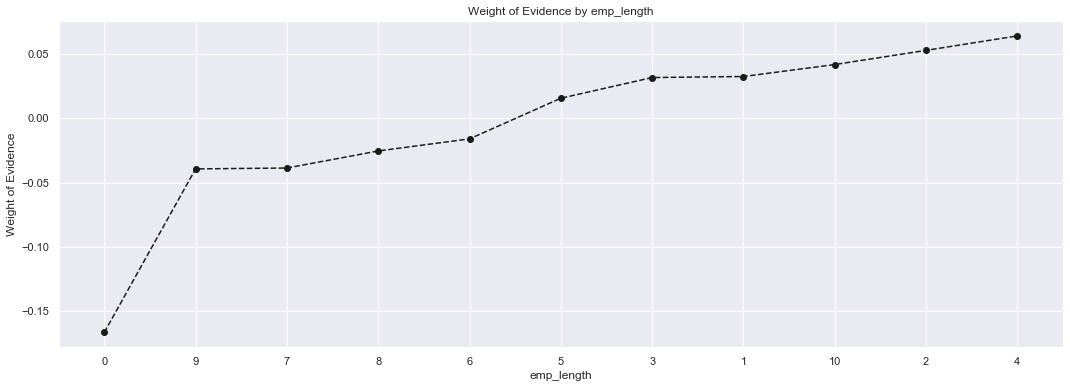

In [49]:
plot_by_woe(emp_len_woe)

IV value 0.004 < 0.02 indicates that term variable is not a useful predictior<br>

#### WOE & IV for annual_inc

(array([1.8166e+05, 9.4000e+01, 7.0000e+00, 5.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([3.0000e+03, 6.1270e+05, 1.2224e+06, 1.8321e+06, 2.4418e+06,
        3.0515e+06, 3.6612e+06, 4.2709e+06, 4.8806e+06, 5.4903e+06,
        6.1000e+06]),
 <a list of 10 Patch objects>)

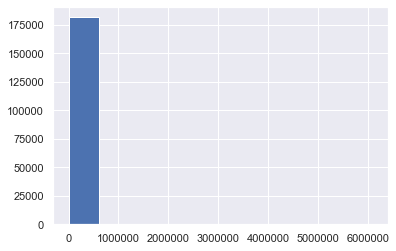

In [50]:
plt.hist(train_df['annual_inc'])

In [51]:
train_df['annual_inc'].describe()

count    1.817710e+05
mean     7.211010e+04
std      5.483136e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.200000e+04
75%      8.611200e+04
max      6.100000e+06
Name: annual_inc, dtype: float64

In [52]:
train_df['annual_inc_cat'],annual_inc_bin =  pd.cut(train_df['annual_inc'],bins=3,retbins=True)
train_df['annual_inc_cat'].sample(3)

135676    (-3097.0, 2035333.333]
371087    (-3097.0, 2035333.333]
365450    (-3097.0, 2035333.333]
Name: annual_inc_cat, dtype: category
Categories (3, interval[float64]): [(-3097.0, 2035333.333] < (2035333.333, 4067666.667] < (4067666.667, 6100000.0]]

In [53]:
annual_inc= get_woe_iv('annual_inc_cat',train_df)
annual_inc

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
annual_inc_cat,,,,,,
"(-3097.0, 2035333.333]",33980.5,147785.5,0.999953,0.999971,-0.000018,0.000012
"(2035333.333, 4067666.667]",0.5,2.5,0.000017,0.000015,0.139445,0.000012
"(4067666.667, 6100000.0]",0.5,4.5,0.000030,0.000015,0.727232,0.000012


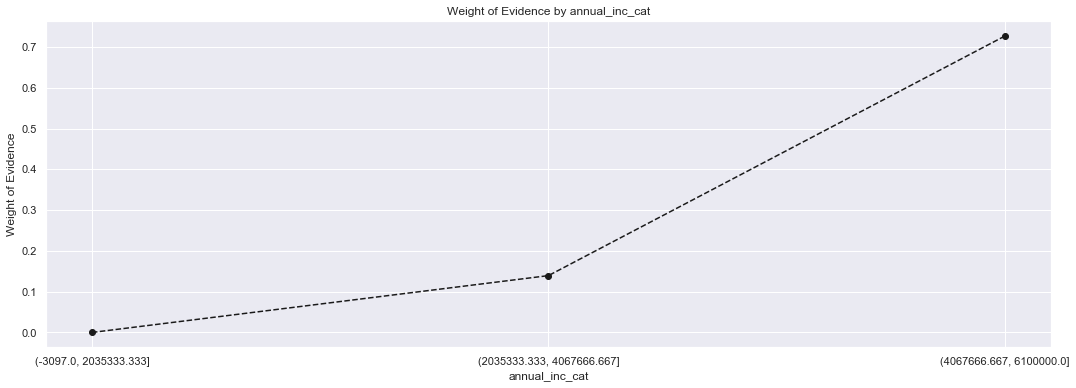

In [54]:
plot_by_woe(annual_inc)

IV value  < 0.02 indicates that annual income is not an useful predictor<br>

#### WOE & IV for dti

(array([ 8447., 18794., 28750., 34367., 32884., 27090., 17385.,  9699.,
         3921.,   434.]),
 array([ 0.   ,  3.999,  7.998, 11.997, 15.996, 19.995, 23.994, 27.993,
        31.992, 35.991, 39.99 ]),
 <a list of 10 Patch objects>)

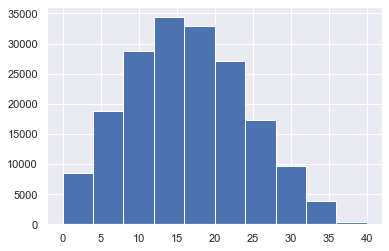

In [55]:
plt.hist(train_df['dti'])

In [56]:
train_df['dti_cat'],annual_inc_bin =  pd.cut(train_df['dti'],bins=5,retbins=True)
train_df['dti_cat'].sample(3)

1063        (-0.04, 7.998]
440505    (23.994, 31.992]
382464     (7.998, 15.996]
Name: dti_cat, dtype: category
Categories (5, interval[float64]): [(-0.04, 7.998] < (7.998, 15.996] < (15.996, 23.994] < (23.994, 31.992] < (31.992, 39.99]]

In [57]:
dti_woe= get_woe_iv('dti_cat',train_df)
dti_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
dti_cat,,,,,,
"(31.992, 39.99]",1351.5,3004.5,0.020329,0.039770,-0.671074,0.082869
"(23.994, 31.992]",7016.5,20068.5,0.135787,0.206474,-0.419083,0.082869
"(15.996, 23.994]",12077.5,47897.5,0.324084,0.355404,-0.092251,0.082869
"(7.998, 15.996]",9996.5,53121.5,0.359431,0.294166,0.200376,0.082869
"(-0.04, 7.998]",3540.5,23701.5,0.160369,0.104186,0.431300,0.082869


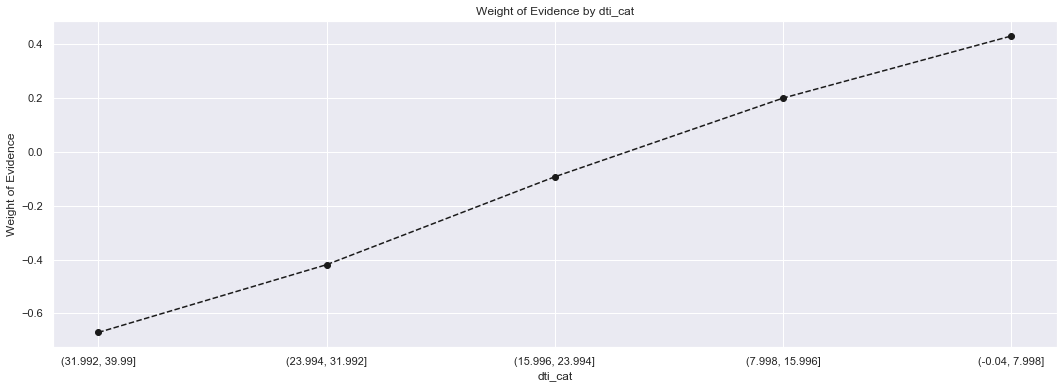

In [58]:
plot_by_woe(dti_woe)

IV value of 0.08 indicates that dti is a weak l predictor<br>
from graph it is clear that there is no need for coarse classing dti variable

#### WOE & IV for delinq_2yrs

(array([1.78461e+05, 2.88100e+03, 3.29000e+02, 6.40000e+01, 2.70000e+01,
        4.00000e+00, 3.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <a list of 10 Patch objects>)

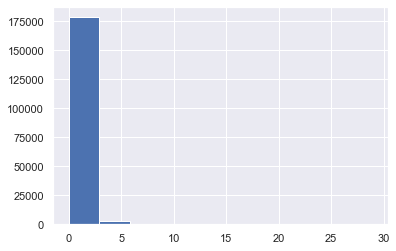

In [59]:
plt.hist(train_df['delinq_2yrs'])

In [60]:
train_df['delinq_2yrs'].value_counts()

0.0     153167
1.0      19863
2.0       5431
3.0       1798
4.0        705
5.0        378
6.0        179
7.0        100
8.0         50
9.0         33
10.0        20
12.0        19
11.0        11
13.0         4
14.0         4
15.0         2
18.0         2
16.0         1
29.0         1
17.0         1
22.0         1
19.0         1
Name: delinq_2yrs, dtype: int64

In [61]:
train_df['delinq_2yrs_cat'],delinq_2yrs_bin =  pd.cut(train_df['delinq_2yrs'],bins=10,retbins=True)
train_df['delinq_2yrs_cat'].sample(3)

63441     (-0.029, 2.9]
48411     (-0.029, 2.9]
184480    (-0.029, 2.9]
Name: delinq_2yrs_cat, dtype: category
Categories (10, interval[float64]): [(-0.029, 2.9] < (2.9, 5.8] < (5.8, 8.7] < (8.7, 11.6] ... (17.4, 20.3] < (20.3, 23.2] < (23.2, 26.1] < (26.1, 29.0]]

In [62]:
delinq_2yrs_woe= get_woe_iv('delinq_2yrs_cat',train_df)
delinq_2yrs_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
delinq_2yrs_cat,,,,,,
"(14.5, 17.4]",2.5,2.5,0.000017,0.000074,-1.469925,0.001907
"(11.6, 14.5]",11.5,16.5,0.000112,0.000338,-1.108912,0.001907
"(17.4, 20.3]",1.5,2.5,0.000017,0.000044,-0.959099,0.001907
"(20.3, 23.2]",0.5,1.5,0.000010,0.000015,-0.371313,0.001907
"(26.1, 29.0]",0.5,1.5,0.000010,0.000015,-0.371313,0.001907
"(5.8, 8.7]",77.5,252.5,0.001708,0.002280,-0.288792,0.001907
"(2.9, 5.8]",671.5,2210.5,0.014956,0.019759,-0.278465,0.001907
"(8.7, 11.6]",13.5,51.5,0.000348,0.000397,-0.131033,0.001907
"(-0.029, 2.9]",33205.5,145256.5,0.982821,0.977078,0.005861,0.001907


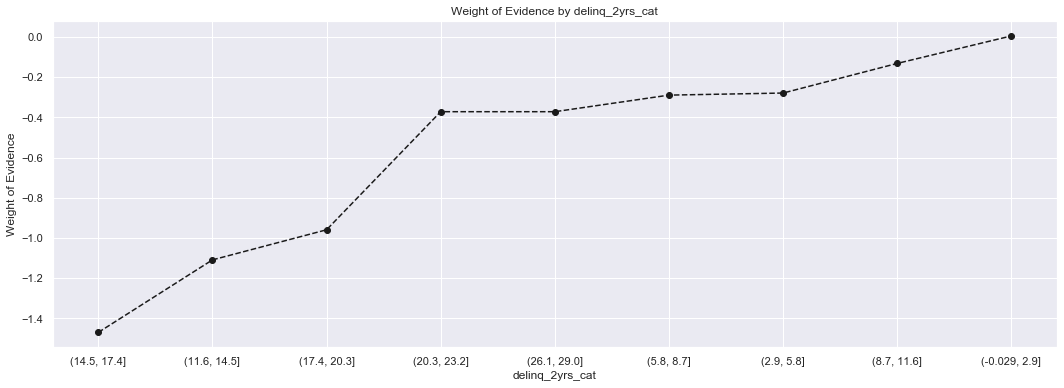

In [63]:
plot_by_woe(delinq_2yrs_woe)

IV value  < 0.02 indicates that delinq_2yrs is not an useful predictor<br>

#### WOE & IV for total_acc

(array([2.9507e+04, 7.5321e+04, 4.9122e+04, 2.0770e+04, 5.3400e+03,
        1.5820e+03, 9.1000e+01, 3.3000e+01, 4.0000e+00, 1.0000e+00]),
 array([  2. ,  13.6,  25.2,  36.8,  48.4,  60. ,  71.6,  83.2,  94.8,
        106.4, 118. ]),
 <a list of 10 Patch objects>)

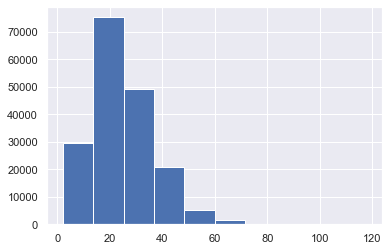

In [64]:
plt.hist(train_df['total_acc'])

In [65]:
train_df['total_acc'].describe()

count    181771.000000
mean         24.813722
std          11.611672
min           2.000000
25%          16.000000
50%          23.000000
75%          32.000000
max         118.000000
Name: total_acc, dtype: float64

In [66]:
train_df['total_acc_cat'],total_acc_bin =  pd.cut(train_df['total_acc'],bins=6,retbins=True)
train_df['total_acc_cat'].sample(3)

444156    (21.333, 40.667]
193009      (40.667, 60.0]
146047     (1.884, 21.333]
Name: total_acc_cat, dtype: category
Categories (6, interval[float64]): [(1.884, 21.333] < (21.333, 40.667] < (40.667, 60.0] < (60.0, 79.333] < (79.333, 98.667] < (98.667, 118.0]]

In [67]:
total_acc_woe= get_woe_iv('total_acc_cat',train_df)
total_acc_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
total_acc_cat,,,,,,
"(79.333, 98.667]",10.5,39.5,0.000267,0.000309,-0.145034,0.004012
"(1.884, 21.333]",15707.5,63862.5,0.432105,0.462216,-0.067365,0.004012
"(21.333, 40.667]",15158.5,68866.5,0.465963,0.446061,0.043649,0.004012
"(40.667, 60.0]",2868.5,13829.5,0.093573,0.084410,0.103056,0.004012
"(60.0, 79.333]",237.5,1191.5,0.008062,0.006989,0.142842,0.004012
"(98.667, 118.0]",0.5,4.5,0.000030,0.000015,0.727266,0.004012


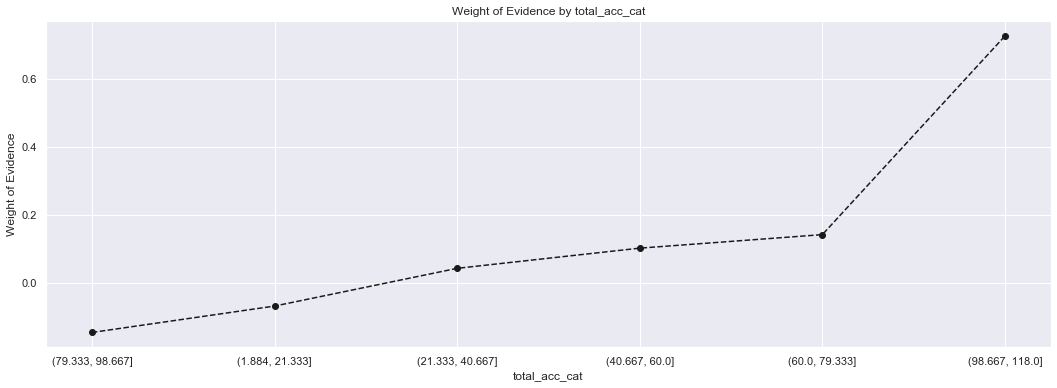

In [68]:
plot_by_woe(total_acc_woe)

IV value  < 0.02 indicates that total_acc is not an useful predictor<br>

#### WOE & IV for credit_hist

(array([2.1756e+04, 7.7637e+04, 5.1230e+04, 2.0382e+04, 7.3380e+03,
        2.5580e+03, 7.1500e+02, 1.3700e+02, 1.5000e+01, 3.0000e+00]),
 array([ 99. , 179.1, 259.2, 339.3, 419.4, 499.5, 579.6, 659.7, 739.8,
        819.9, 900. ]),
 <a list of 10 Patch objects>)

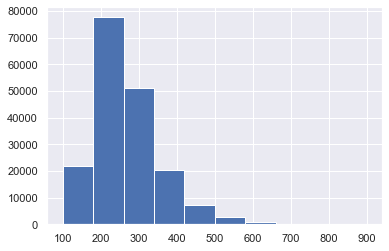

In [69]:
plt.hist(train_df['credit_hist'])

In [70]:
train_df['credit_hist'].describe()

count    181771.000000
mean        267.777940
std          84.563009
min          99.000000
25%         211.000000
50%         251.000000
75%         309.000000
max         900.000000
Name: credit_hist, dtype: float64

In [71]:
train_df['credit_hist_cat'],credit_hist_bin =  pd.cut(train_df['credit_hist'],bins=10,retbins=True)
train_df['credit_hist_cat'].sample(3)

93945     (259.2, 339.3]
55917     (179.1, 259.2]
157173    (259.2, 339.3]
Name: credit_hist_cat, dtype: category
Categories (10, interval[float64]): [(98.199, 179.1] < (179.1, 259.2] < (259.2, 339.3] < (339.3, 419.4] ... (579.6, 659.7] < (659.7, 739.8] < (739.8, 819.9] < (819.9, 900.0]]

In [72]:
credit_hist_woe= get_woe_iv('credit_hist_cat',train_df)
credit_hist_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
credit_hist_cat,,,,,,
"(739.8, 819.9]",5.5,10.5,0.000071,0.000162,-0.823287,0.010595
"(659.7, 739.8]",38.5,99.5,0.000673,0.001133,-0.520414,0.010595
"(98.199, 179.1]",4801.5,16955.5,0.114722,0.141283,-0.208250,0.010595
"(579.6, 659.7]",147.5,568.5,0.003847,0.004340,-0.120741,0.010595
"(179.1, 259.2]",14886.5,62751.5,0.424582,0.438031,-0.031186,0.010595
"(259.2, 339.3]",9030.5,42200.5,0.285532,0.265720,0.071911,0.010595
"(499.5, 579.6]",436.5,2122.5,0.014361,0.012844,0.111648,0.010595
"(419.4, 499.5]",1243.5,6095.5,0.041243,0.036590,0.119707,0.010595
"(339.3, 419.4]",3394.5,16988.5,0.114946,0.099882,0.140466,0.010595


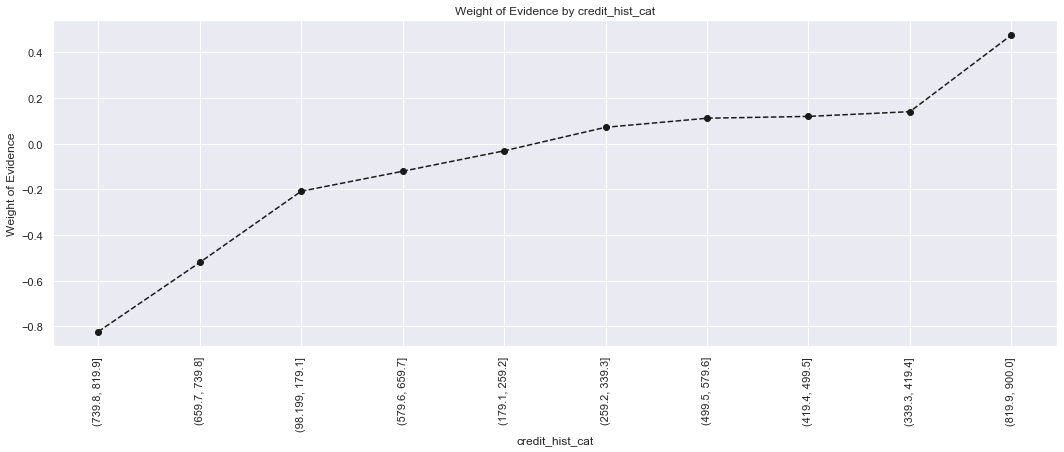

In [73]:
plot_by_woe(credit_hist_woe,90)

IV value  < 0.02 indicates that term annual income is not an useful predictor<br>

#### WOE & IV for purpose

In [74]:
purpose_woe = get_woe_iv('purpose',train_df)
purpose_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
purpose,,,,,,
small_business,1037.5,2550.5,0.017257,0.030526,-0.570393,0.024648
moving,311.5,1130.5,0.007649,0.009165,-0.180852,0.024648
other,2212.5,8032.5,0.054348,0.065098,-0.180496,0.024648
renewable_energy,41.5,153.5,0.001039,0.001221,-0.161861,0.024648
medical,421.5,1663.5,0.011255,0.012402,-0.097009,0.024648
debt_consolidation,20636.5,85105.5,0.575823,0.607188,-0.053038,0.024648
house,208.5,951.5,0.006438,0.006135,0.048232,0.024648
vacation,202.5,924.5,0.006255,0.005958,0.048645,0.024648
educational,44.5,208.5,0.001411,0.001309,0.074581,0.024648


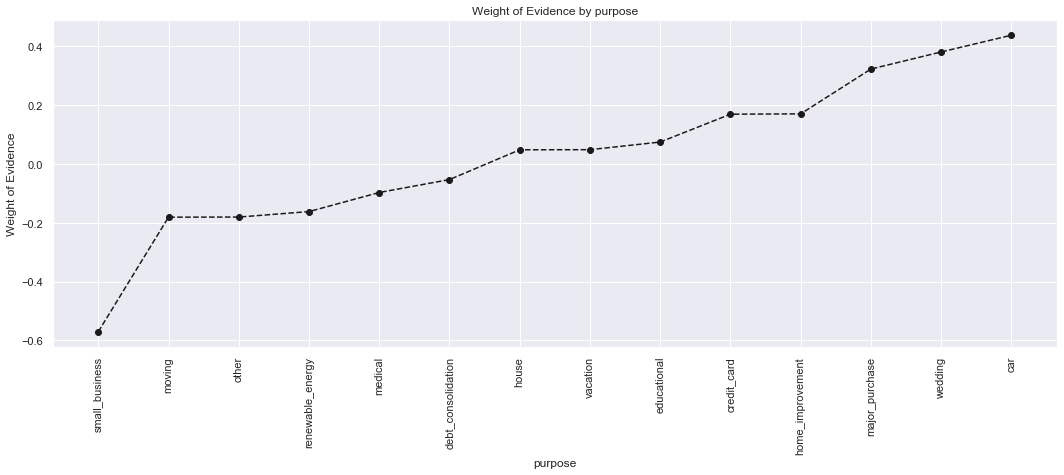

In [75]:
plot_by_woe(purpose_woe,90)

IV value  > 0.02 indicates that purpose is weak predictor<br>
From graph it is clear that purpose needs to be coarse classing

In [76]:
# coarse classing purpose categories
# combining categories with similariy WOE or having less than of obs
cat_1 = ['moving','other','renewable_energy']
cat_2 = ['house','vacation','educational']
cat_3 = ['credit_card','home_improvement']
cat_4 = ['major_purchase','wedding','car']
cat_4 = ['debt_consolidation','medical']

purpose_coarse_classing = {'moving': 'cat_1','other':'cat_1','renewable_energy':'cat_1',
                          'house':'cat_2','vacation':'cat_2','educational':'cat_2',
                          'credit_card':'cat_3','home_improvement':'cat_3',
                          'major_purchase':'cat_4','wedding':'cat_4','car':'cat_4',
                          'medical':'cat_5','debt_consolidation':'cat_5'}

train_df['purpose'].replace(purpose_coarse_classing,inplace=True)

In [77]:
purpose_woe = get_woe_iv('purpose',train_df)
purpose_woe

,Bad_loan,Good_loan,Good_loan_prop,Bad_loan_prop,WOE,IV
purpose,,,,,,
small_business,1037.5,2550.5,0.017257,0.030530,-0.570484,0.024531
cat_1,2564.5,9315.5,0.063030,0.075464,-0.180043,0.024531
cat_5,21057.5,86768.5,0.587091,0.619648,-0.053972,0.024531
cat_2,454.5,2083.5,0.014097,0.013374,0.052648,0.024531
cat_3,7650.5,39417.5,0.266706,0.225127,0.169480,0.024531
cat_4,1218.5,7658.5,0.051819,0.035856,0.368237,0.024531


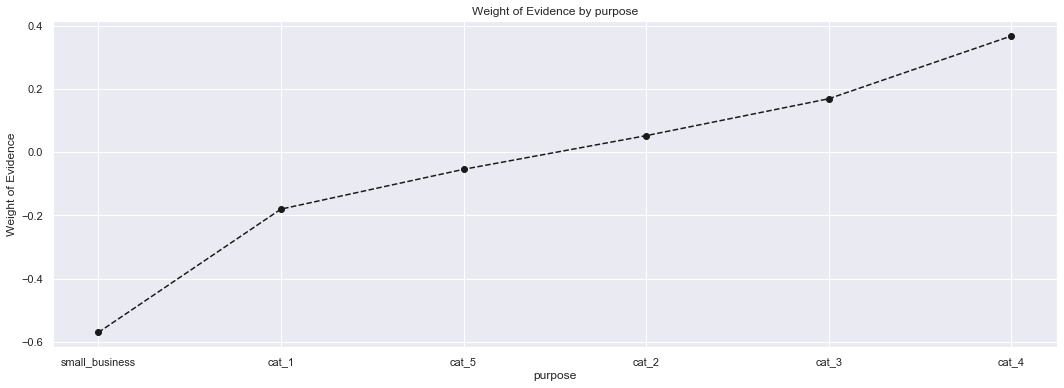

In [78]:
plot_by_woe(purpose_woe,)

### Final Train dataset preparation

In [79]:
# feature selected based on the IV value
imp_feature = ['id','member_id','grade','verification_status','loan_amnt','term','dti','purpose','Good_loan']
final_train = train_df[imp_feature].copy()
final_train.sample(3)

,id,member_id,grade,verification_status,loan_amnt,term,dti,purpose,Good_loan
411896,13867786,15920131,D,Source Verified,35000,60,14.45,cat_3,0
197552,1538862,1804209,C,Source Verified,12000,36,8.19,cat_5,1
163210,3370096,4222989,B,Verified,18000,36,15.65,cat_5,0


In [80]:
loan_amt_bin

array([  465.5,  7400. , 14300. , 21200. , 28100. , 35000. ])

In [81]:
# converting loan amount to catgeory 
train_df['loan_amnt_cat']

399665     (7400.0, 14300.0]
94773     (21200.0, 28100.0]
173800    (14300.0, 21200.0]
2634         (465.5, 7400.0]
445285    (28100.0, 35000.0]
                 ...        
229667    (14300.0, 21200.0]
81652        (465.5, 7400.0]
36686      (7400.0, 14300.0]
24057     (14300.0, 21200.0]
2332      (14300.0, 21200.0]
Name: loan_amnt_cat, Length: 181771, dtype: category
Categories (5, interval[float64]): [(465.5, 7400.0] < (7400.0, 14300.0] < (14300.0, 21200.0] < (21200.0, 28100.0] < (28100.0, 35000.0]]

In [82]:
# function for converting loan amount to category
def get_loan_cat(amount):
    if amount < 7400:
        cat = 'below_74'
    elif amount >= 7400 and amount < 14300:
        cat = 'bet_74_143'
    elif amount >= 14300 and amount < 21200 :
        cat = 'bet_143_212'
    elif amount >= 21200 and amount < 28100:
        cat = 'bet_212_281'
    else :
        cat = 'above_281'
    return cat

In [83]:
final_train['loan_amnt'] = final_train['loan_amnt'].apply(get_loan_cat)
final_train['loan_amnt']  =final_train['loan_amnt'].astype(str)
final_train.sample(3)

,id,member_id,grade,verification_status,loan_amnt,term,dti,purpose,Good_loan
403978,14600330,16662623,B,Source Verified,bet_143_212,36,9.19,cat_5,1
37711,376147,385528,C,Source Verified,bet_74_143,36,19.83,cat_4,1
458236,10536755,12418776,C,Verified,bet_143_212,60,18.73,cat_5,1


In [84]:
# converting loan amount to catgeory 
train_df['dti_cat']

399665      (-0.04, 7.998]
94773     (15.996, 23.994]
173800     (7.998, 15.996]
2634        (-0.04, 7.998]
445285    (23.994, 31.992]
                ...       
229667    (15.996, 23.994]
81652      (7.998, 15.996]
36686       (-0.04, 7.998]
24057      (7.998, 15.996]
2332      (23.994, 31.992]
Name: dti_cat, Length: 181771, dtype: category
Categories (5, interval[float64]): [(-0.04, 7.998] < (7.998, 15.996] < (15.996, 23.994] < (23.994, 31.992] < (31.992, 39.99]]

In [85]:
# function for converting dtito category
def get_dti_cat(dti):
    if dti < 8:
        cat = 'below_8'
    elif dti >= 8 and dti < 16:
        cat = 'bet_8_16'
    elif dti >= 16 and dti < 24 :
        cat = 'bet_16_24'
    elif dti >= 24 and dti < 32:
        cat = 'bet_24_32'
    else :
        cat = 'above_32'
    return cat

In [86]:
final_train['dti'] = final_train['dti'].apply(get_dti_cat)
final_train['dti']  =final_train['dti'].astype(str)
final_train.sample(3)

,id,member_id,grade,verification_status,loan_amnt,term,dti,purpose,Good_loan
210582,1387695,1633615,D,Not Verified,bet_74_143,36,bet_16_24,cat_5,1
148515,4185697,5327933,C,Source Verified,below_74,36,bet_8_16,cat_4,1
266273,33320141,35963365,D,Verified,bet_143_212,60,above_32,cat_3,0


In [87]:
## once hot encoding of dummy variables
enc = OneHotEncoder(handle_unknown='ignore')
cat_columns = ['grade','verification_status','loan_amnt','term','dti','purpose']
one_hot_vec = enc.fit_transform(final_train[cat_columns])
one_hot_vec = one_hot_vec.toarray()
one_hot_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [88]:
enc.get_feature_names()

array(['x0_A', 'x0_B', 'x0_C', 'x0_D', 'x0_E', 'x0_F', 'x0_G',
       'x1_Not Verified', 'x1_Source Verified', 'x1_Verified',
       'x2_above_281', 'x2_below_74', 'x2_bet_143_212', 'x2_bet_212_281',
       'x2_bet_74_143', 'x3_36', 'x3_60', 'x4_above_32', 'x4_below_8',
       'x4_bet_16_24', 'x4_bet_24_32', 'x4_bet_8_16', 'x5_cat_1',
       'x5_cat_2', 'x5_cat_3', 'x5_cat_4', 'x5_cat_5',
       'x5_small_business'], dtype=object)

In [89]:
one_hot_df = pd.DataFrame(one_hot_vec,columns=enc.get_feature_names(),index=final_train.index)
one_hot_df.sample(3)

,x0_A,x0_B,x0_C,x0_D,x0_E,x0_F,x0_G,x1_Not Verified,x1_Source Verified,x1_Verified,x2_above_281,x2_below_74,x2_bet_143_212,x2_bet_212_281,x2_bet_74_143,x3_36,x3_60,x4_above_32,x4_below_8,x4_bet_16_24,x4_bet_24_32,x4_bet_8_16,x5_cat_1,x5_cat_2,x5_cat_3,x5_cat_4,x5_cat_5,x5_small_business
120622,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
206914,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
455911,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [90]:
# converting columns name to more meaning full names
one_hot_df.columns = one_hot_df.columns.str.replace('x0_','Grade:')
one_hot_df.columns = one_hot_df.columns.str.replace('x1_','Status:')
one_hot_df.columns = one_hot_df.columns.str.replace('x2_','Loan:')
one_hot_df.columns = one_hot_df.columns.str.replace('x3_','Term:')
one_hot_df.columns = one_hot_df.columns.str.replace('x4_','DTI:')
one_hot_df.columns = one_hot_df.columns.str.replace('x5_','Purpose:')
one_hot_df.columns = one_hot_df.columns.str.replace(' ','_')
one_hot_df.sample(3)

,Grade:A,Grade:B,Grade:C,Grade:D,Grade:E,Grade:F,Grade:G,Status:Not_Verified,Status:Source_Verified,Status:Verified,Loan:above_281,Loan:below_74,Loan:bet_143_212,Loan:bet_212_281,Loan:bet_74_143,Term:36,Term:60,DTI:above_32,DTI:below_8,DTI:bet_16_24,DTI:bet_24_32,DTI:bet_8_16,Purpose:cat_1,Purpose:cat_2,Purpose:cat_3,Purpose:cat_4,Purpose:cat_5,Purpose:small_business
26821,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
190176,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
199518,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [91]:
final_train.shape, one_hot_df.shape

((181771, 9), (181771, 28))

In [92]:
# appending one hot vectors to final train
final_train = pd.concat([final_train,one_hot_df],axis=1,sort=False)
final_train.sample(3)

,id,member_id,grade,verification_status,loan_amnt,term,dti,purpose,Good_loan,Grade:A,Grade:B,Grade:C,Grade:D,Grade:E,Grade:F,Grade:G,Status:Not_Verified,Status:Source_Verified,Status:Verified,Loan:above_281,Loan:below_74,Loan:bet_143_212,Loan:bet_212_281,Loan:bet_74_143,Term:36,Term:60,DTI:above_32,DTI:below_8,DTI:bet_16_24,DTI:bet_24_32,DTI:bet_8_16,Purpose:cat_1,Purpose:cat_2,Purpose:cat_3,Purpose:cat_4,Purpose:cat_5,Purpose:small_business
136956,5155930,6478186,B,Not Verified,bet_74_143,36,bet_16_24,cat_5,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
241412,36049015,38760601,B,Not Verified,bet_74_143,60,below_8,cat_3,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
104230,6637309,8219431,A,Verified,bet_143_212,36,bet_16_24,cat_3,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [93]:
# drop cat columns
final_train.drop(cat_columns,axis='columns',inplace=True)
final_train.sample(3)

,id,member_id,Good_loan,Grade:A,Grade:B,Grade:C,Grade:D,Grade:E,Grade:F,Grade:G,Status:Not_Verified,Status:Source_Verified,Status:Verified,Loan:above_281,Loan:below_74,Loan:bet_143_212,Loan:bet_212_281,Loan:bet_74_143,Term:36,Term:60,DTI:above_32,DTI:below_8,DTI:bet_16_24,DTI:bet_24_32,DTI:bet_8_16,Purpose:cat_1,Purpose:cat_2,Purpose:cat_3,Purpose:cat_4,Purpose:cat_5,Purpose:small_business
110438,6326661,7858446,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
218019,1273389,1516768,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
172247,3146696,3858998,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [94]:
final_train.shape

(181771, 31)

### Full routine to process raw data

In [95]:
# function for converting dtito category
def get_dti_cat(dti):
    if dti < 8:
        cat = 'below_8'
    elif dti >= 8 and dti < 16:
        cat = 'bet_8_16'
    elif dti >= 16 and dti < 24 :
        cat = 'bet_16_24'
    elif dti >= 24 and dti < 32:
        cat = 'bet_24_32'
    else :
        cat = 'above_32'
    return cat

# function for converting loan amount to category
def get_loan_cat(amount):
    if amount < 7400:
        cat = 'below_74'
    elif amount >= 7400 and amount < 14300:
        cat = 'bet_74_143'
    elif amount >= 14300 and amount < 21200 :
        cat = 'bet_143_212'
    elif amount >= 21200 and amount < 28100:
        cat = 'bet_212_281'
    else :
        cat = 'above_281'
    return cat

def process_raw(raw,enc):
    # select feature
    imp_feature = ['id','member_id','grade','verification_status','loan_amnt','term','dti','purpose']
    df = raw[imp_feature].copy()
    
    # Coarse Classing Purpose Variable
    purpose_coarse_classing = {'moving': 'cat_1','other':'cat_1','renewable_energy':'cat_1',
                               'house':'cat_2','vacation':'cat_2','educational':'cat_2',
                               'credit_card':'cat_3','home_improvement':'cat_3',
                               'major_purchase':'cat_4','wedding':'cat_4','car':'cat_4',
                               'medical':'cat_5','debt_consolidation':'cat_5'}

    df['purpose'].replace(purpose_coarse_classing,inplace=True)
    
    # Discretize Loan amount
    df['loan_amnt'] = df['loan_amnt'].apply(get_loan_cat)
    df['loan_amnt'] = df['loan_amnt'].astype(str)
    
    # Discretize dti amount
    df['dti'] = df['dti'].apply(get_dti_cat)
    df['dti'] = df['dti'].astype(str)
    
    # converting term from str to int
    df['term'] = df['term'].apply(lambda x : x.split()[0])
    df['term'] = df['term'].astype(int)
    
    # one hot category columns
    cat_columns = ['grade','verification_status','loan_amnt','term','dti','purpose']
    one_hot_vec = enc.transform(df[cat_columns])
    one_hot_vec = one_hot_vec.toarray()
    
    one_hot_df = pd.DataFrame(one_hot_vec,columns=enc.get_feature_names(),index=df.index)
    
    # converting columns name to more meaning full names
    one_hot_df.columns = one_hot_df.columns.str.replace('x0_','Grade:')
    one_hot_df.columns = one_hot_df.columns.str.replace('x1_','Status:')
    one_hot_df.columns = one_hot_df.columns.str.replace('x2_','Loan:')
    one_hot_df.columns = one_hot_df.columns.str.replace('x3_','Term:')
    one_hot_df.columns = one_hot_df.columns.str.replace('x4_','DTI:')
    one_hot_df.columns = one_hot_df.columns.str.replace('x5_','Purpose:')
    one_hot_df.columns = one_hot_df.columns.str.replace(' ','_')
    
    # drop cateory columns
    df.drop(cat_columns,axis='columns',inplace=True)
    
    # concat dataframes
    df = pd.concat([df,one_hot_df],axis=1,sort=False)
    
    return df

### Prepare Eval and Test data set

In [96]:
final_eval = process_raw(raw_eval,enc)
final_eval.head(3)

,id,member_id,Grade:A,Grade:B,Grade:C,Grade:D,Grade:E,Grade:F,Grade:G,Status:Not_Verified,Status:Source_Verified,Status:Verified,Loan:above_281,Loan:below_74,Loan:bet_143_212,Loan:bet_212_281,Loan:bet_74_143,Term:36,Term:60,DTI:above_32,DTI:below_8,DTI:bet_16_24,DTI:bet_24_32,DTI:bet_8_16,Purpose:cat_1,Purpose:cat_2,Purpose:cat_3,Purpose:cat_4,Purpose:cat_5,Purpose:small_business
387503,15500782,17593205,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9612,846710,1058128,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
296640,17653556,19786090,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [97]:
raw_eval.shape, final_eval.shape

((45443, 74), (45443, 30))

In [98]:
# creating target variable Good Loan which is set to 1 if loan is fully paid else it is 0
final_eval['Good_loan'] = np.where(raw_eval['loan_status']=='Fully Paid',1,0)
final_eval['Good_loan'].value_counts()

1    36948
0     8495
Name: Good_loan, dtype: int64

In [99]:
final_test = process_raw(raw_test,enc)
final_test.head(3)

,id,member_id,Grade:A,Grade:B,Grade:C,Grade:D,Grade:E,Grade:F,Grade:G,Status:Not_Verified,Status:Source_Verified,Status:Verified,Loan:above_281,Loan:below_74,Loan:bet_143_212,Loan:bet_212_281,Loan:bet_74_143,Term:36,Term:60,DTI:above_32,DTI:below_8,DTI:bet_16_24,DTI:bet_24_32,DTI:bet_8_16,Purpose:cat_1,Purpose:cat_2,Purpose:cat_3,Purpose:cat_4,Purpose:cat_5,Purpose:small_business
4,1075358,1311748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1069639,1304742,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32,1065420,1299514,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Save the dataset

In [100]:
final_train.to_csv('Processed_Train.csv',index=False)
final_eval.to_csv('Processed_Eval.csv',index=False)
final_test.to_csv('Processed_Test.csv',index=False)

In [102]:
# Save the fitted one hot encoder
pickle.dump(enc, open( "PD_One_hot.pkl", "wb" ) )